# Data Analysis for MultiClaim Sample Data

In [1]:
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from src.datasets import TextConcatPosts, TextConcatFactCheck
import pandas as pd

POSTS_PATH = "data/complete_data/posts.csv"
FACT_CHECKS_PATH = "data/complete_data/fact_checks.csv"
TASKS_PATH = "data/splits/tasks.json"
GS_PATH = "data/complete_data/pairs.csv"
PHASE1_TASKS_PATH = "data/complete_data/tasks.json"
OUTPUT_PATH = "out"
LANGS = ['eng', 'fra', 'deu', 'por', 'spa', 'tha',  'msa', 'ara']

TASK_NAME = "monolingual"
LANG = "eng"

time_start = time()
posts = TextConcatPosts(POSTS_PATH, TASKS_PATH, task_name=TASK_NAME, gs_path=GS_PATH, lang=LANG)
print(f"Loaded {len(posts)}")
print(f"Time taken: {time() - time_start:.2f}s\n")

print("Loading fact checks..")
time_start = time()
fact_checks = TextConcatFactCheck(FACT_CHECKS_PATH, TASKS_PATH, task_name=TASK_NAME, lang=LANG)
print(f"Loaded {len(fact_checks)}")
print(f"Time taken: {time() - time_start:.2f}s\n")

Loaded 4829
Time taken: 0.88s

Loading fact checks..
Loaded 85734
Time taken: 6.65s



In [2]:
# Test
from src import config

# Hardcoded paths
fact_checks_path = "data/test_data/fact_checks.csv"
posts_path = "data/test_data/posts.csv"
tasks_path = "data/splits/splits_test.json"
gs_path = config.GS_PATH

# Load Fact Checks
print("Loading Fact Checks...")
fc = TextConcatFactCheck(fact_checks_path, tasks_path=tasks_path, task_name=TASK_NAME, lang=LANG, version="english")

# Load Posts
print("Loading Posts...")
posts = TextConcatPosts(posts_path, tasks_path=tasks_path, task_name=TASK_NAME, lang=LANG, gs_path=gs_path, version="english")


Loading Fact Checks...
Loading Posts...


In [3]:
# Load task files:
import json
d_tasks_train = json.load(open("data/splits/tasks.json"))
d_tasks_test = json.load(open("data/splits/splits_test.json"))

In [4]:
# Count the number of posts and fact check for train and test

# Total Number of Posts and Fact Checks by Tasks

**Observations:**
- Checking English training data, we can see that there are some training samples that are not in English but their lang columns is in English.
- 153,743 fact checks; 24,431 posts; 25,743 post-fact-checks pairs
- No overlap between the training and test data and between languages

In [5]:
df_posts_total = posts.df
df_train_en = df_posts_total.loc[posts.idx_train]
df_dev_en = df_posts_total.loc[posts.idx_dev]

df_fc = fact_checks.df

import pandas as pd
df_lang_dist = pd.DataFrame()
df_lang_dist["train"] = df_train_en.lan.value_counts()
df_lang_dist["dev"] = df_dev_en.lan.value_counts()
len(df_lang_dist)

1

## Monolingual

In [18]:
d_tasks_train["monolingual"].keys()

dict_keys(['ara', 'deu', 'eng', 'fra', 'msa', 'pol', 'por', 'spa', 'tha', 'tur'])

In [108]:
d_tasks_test["crosslingual"].keys()

dict_keys(['fact_checks', 'posts_test', 'posts_train', 'posts_dev'])

In [6]:
import collections

d_tasks_train = json.load(open("data/splits/tasks.json"))
d_tasks_test = json.load(open("data/splits/splits_test.json"))

def count_per_lang(d_task, lang=None):
    d_posts = {}
    d_fcs = {}
    if lang is None:
        langs = d_task.keys()
    else:
        d_task = {lang: d_task}
        langs = [lang]
        
    for lan in langs:
        d_posts[lan] = {"train": [], "dev": [], "total": []}
        d_posts[lan]["train"].extend(d_task[lan]["posts_train"])
        d_posts[lan]["dev"].extend(d_task[lan]["posts_dev"])
        d_posts[lan]["total"] = d_posts[lan]["train"] + d_posts[lan]["dev"]
        
        d_fcs[lan] = {"fact_checks": []}
        d_fcs[lan]["fact_checks"].extend(d_task[lan]["fact_checks"])
        
    # Check if there are duplicates
    for lan in d_posts:
        # print(f"Not overlapping posts for {lan}")
        assert len(d_posts[lan]["total"]) == len(set(d_posts[lan]["total"])), f"Duplicate posts found for {lan}"
        
        repeated = [item for item, count in collections.Counter(d_fcs[lan]["fact_checks"]).items() if count > 1]
        assert len(repeated) == 0, f"Duplicate fact checks found for {lan}"

    df_posts_an = pd.DataFrame(d_posts)
    df_out = df_posts_an.map(len)

    df_fcs_an_0 = pd.DataFrame(d_fcs)
    df_fcs_an = df_fcs_an_0.map(len)

    # df_out = pd.concat([df_out, df_fcs_an], axis=0)

    df_out["total"] = df_out.sum(axis=1)
    
    return df_out, df_fcs_an

df_out_train, df_fcs_train = count_per_lang(d_tasks_train["monolingual"])
print(df_out_train, "\n")
print(df_fcs_train)

        fra   spa   eng   por  tha  deu   msa  ara  total
train  1596  5628  4351  2571  465  667  1062  676  17016
dev     188   615   478   302   42   83   105   78   1891
total  1784  6243  4829  2873  507  750  1167  754  18907 

              fra    spa    eng    por  tha   deu   msa    ara
fact_checks  4355  14082  85734  21569  382  4996  8424  14201


In [7]:
df_out_test, df_fcs_test = count_per_lang(d_tasks_test["monolingual"])
df_out_test = df_out_test.loc[["dev"], :].rename(index={"dev": "test"}).fillna(0)
df_fcs_test = df_fcs_test.loc[["fact_checks"], :].rename(index={"fact_checks": "fact_checks_test"}).fillna(0)
print(df_out_test.to_markdown(), "\n")
print(df_fcs_test.to_markdown())

|      |   ara |   deu |   eng |   fra |   msa |   pol |   por |   spa |   tha |   tur |   total |
|:-----|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|--------:|
| test |   500 |   500 |   500 |   500 |    93 |   500 |   500 |   500 |   183 |   500 |    4276 | 

|                  |   ara |   deu |    eng |   fra |   msa |   pol |   por |   spa |   tha |   tur |
|:-----------------|------:|------:|-------:|------:|------:|------:|------:|------:|------:|------:|
| fact_checks_test | 21153 |  7485 | 145287 |  6316 |   686 |  8796 | 32598 | 25440 |   583 | 12536 |


In [8]:
df_fcs_test

,ara,deu,eng,fra,msa,pol,por,spa,tha,tur
fact_checks_test,21153,7485,145287,6316,686,8796,32598,25440,583,12536


In [9]:
df_out_final = pd.concat([df_out_train, df_out_test], axis=0).drop("total", axis=0).fillna(0).drop("total", axis=1)
df_out_final.loc["total", :] = df_out_final.sum(axis=0)
df_out_final["total"] = df_out_final.sum(axis=1)
df_out_final = df_out_final.astype(int)
df_out_final

,fra,spa,eng,por,tha,deu,msa,ara,pol,tur,total
train,1596,5628,4351,2571,465,667,1062,676,0,0,17016
dev,188,615,478,302,42,83,105,78,0,0,1891
test,500,500,500,500,183,500,93,500,500,500,4276
total,2284,6743,5329,3373,690,1250,1260,1254,500,500,23183


In [10]:
df_fcs_final = pd.concat([df_fcs_train, df_fcs_test], axis=0).fillna(0)
df_fcs_final.loc["total", :] = df_fcs_final.sum(axis=0)
df_fcs_final["total"] = df_fcs_final.sum(axis=1)
df_fcs_final = df_fcs_final.astype(int)
df_fcs_final

,fra,spa,eng,por,tha,deu,msa,ara,pol,tur,total
fact_checks,4355,14082,85734,21569,382,4996,8424,14201,0,0,153743
fact_checks_test,6316,25440,145287,32598,583,7485,686,21153,8796,12536,260880
total,10671,39522,231021,54167,965,12481,9110,35354,8796,12536,414623


In [11]:
df_out_ctr, df_fcs_ctr = count_per_lang(d_tasks_train["crosslingual"], lang="cross")
df_out_cts, df_fcs_cts = count_per_lang(d_tasks_test["crosslingual"], lang="cross")

In [12]:
print(len(d_tasks_test["crosslingual"]["fact_checks"]))
print(len(d_tasks_train["crosslingual"]["fact_checks"]))
print(len(set(d_tasks_test["crosslingual"]["fact_checks"]).intersection(set(d_tasks_train["crosslingual"]["fact_checks"]))))
print(len(set(d_tasks_test["crosslingual"]["fact_checks"]).union(set(d_tasks_train["crosslingual"]["fact_checks"]))))

272447
153743
144823
281367


In [13]:
print(df_out_ctr, "\n")
print(df_fcs_ctr, "\n")
print(df_out_cts, "\n")
print(df_fcs_cts)


       cross  total
train   4972   4972
dev      552    552
total   5524   5524 

              cross
fact_checks  153743 

       cross  total
train      0      0
dev     4000   4000
total   4000   4000 

              cross
fact_checks  272447


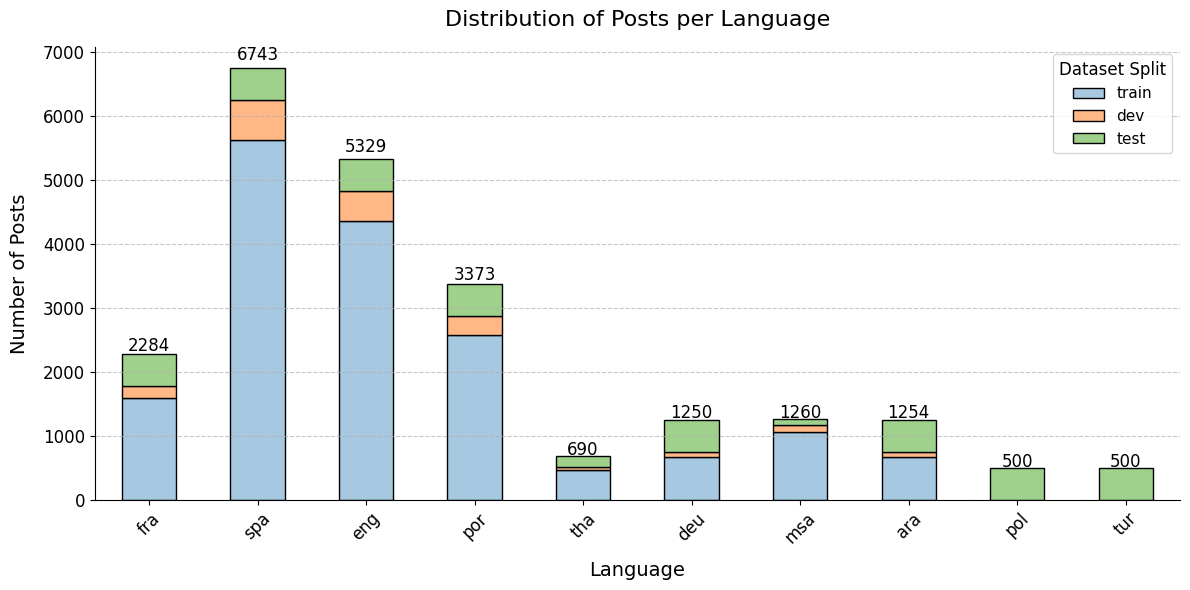

In [ ]:
import matplotlib.pyplot as plt

title_fontsize = 20
xtick_fontsize = 18
ytick_fontsize = 18

# Define colors for a professional, high-contrast look
colors = ["#A6C8E1", "#FFB785", "#9FD18C", "#E79C9C", "#C2A5D5", "#C8B8A2"]

# Create the plot
ax = df_out_final.iloc[:-1, :-1].T.plot(kind="bar", figsize=(12, 6), stacked=True, color=colors, edgecolor="black")

# Title & Labels
plt.title("Distribution of Posts per Language", fontsize=title_fontsize, pad=15)
plt.xlabel("Language", fontsize=14, labelpad=10)
plt.ylabel("Number of Posts", fontsize=14, labelpad=10)

# Legend
plt.legend(title="Dataset Split", title_fontsize=12, fontsize=11, loc="upper right", frameon=True)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Improve X-axis labels (rotate for clarity)
plt.xticks(rotation=45, fontsize=12)

# Increase Y-axis font size
plt.yticks(fontsize=12)

# Remove top and right borders for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Annotate total amount on top of each bar
totals = df_out_final.iloc[:-1, :-1].T.sum(axis=1)  # Compute total per language
for i, total in enumerate(totals):
    ax.text(i, total + total * 0.02, f"{int(total)}", ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig("nbs/data_exploration/plots/final_monolingual_distribution.png")
plt.show()


In [137]:
df_fcs_final

,fra,spa,eng,por,tha,deu,msa,ara,pol,tur,total
fact_checks,4355,14082,85734,21569,382,4996,8424,14201,0,0,153743
fact_checks_test,6316,25440,145287,32598,583,7485,686,21153,8796,12536,260880
total,10671,39522,231021,54167,965,12481,9110,35354,8796,12536,414623


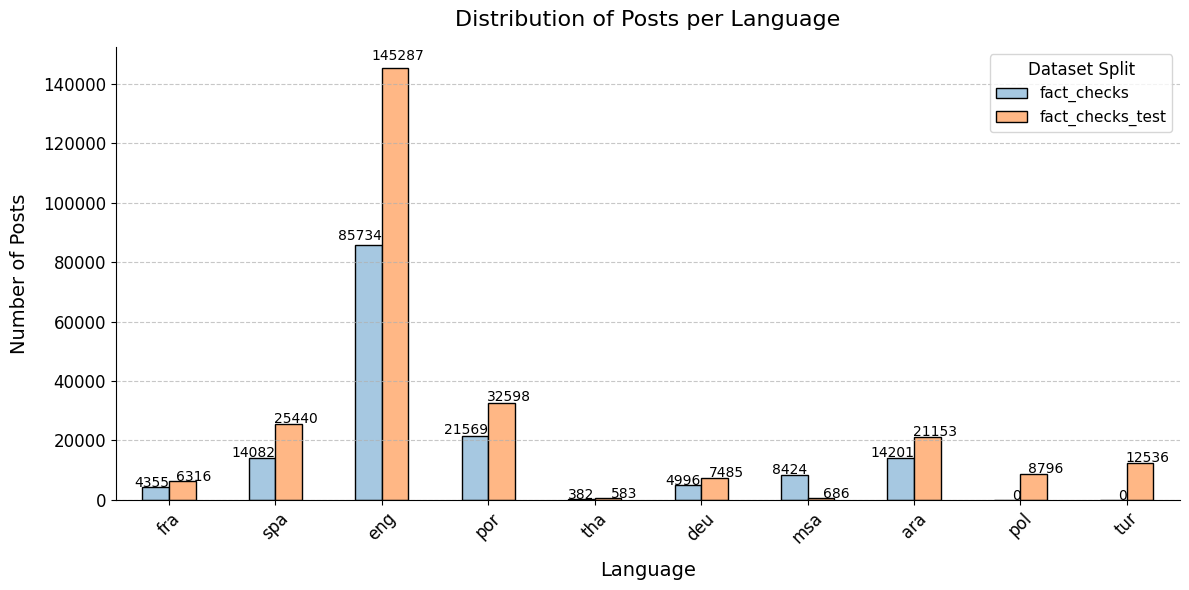

In [160]:
import matplotlib.pyplot as plt

# Define colors for a professional, high-contrast look
colors = ["#A6C8E1", "#FFB785", "#9FD18C", "#E79C9C", "#C2A5D5", "#C8B8A2"]

# Create the plot
ax = df_fcs_final.iloc[:-1, :-1].T.plot(kind="bar", figsize=(12, 6), stacked=False, color=colors, edgecolor="black")

# Title & Labels
plt.title("Distribution of Posts per Language", fontsize=16, pad=15)
plt.xlabel("Language", fontsize=14, labelpad=10)
plt.ylabel("Number of Posts", fontsize=14, labelpad=10)

# Legend
plt.legend(title="Dataset Split", title_fontsize=12, fontsize=11, loc="upper right", frameon=True)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Improve X-axis labels (rotate for clarity)
plt.xticks(rotation=45, fontsize=12)

# Increase Y-axis font size
plt.yticks(fontsize=12)

# Remove top and right borders for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Annotate each value on top of each bar
for i in range(df_fcs_final.shape[0] - 1):
    for j in range(df_fcs_final.shape[1] - 1):
        # if df_fcs_final.iloc[i, j] > 0:
        ax.text(j + i * 0.4, df_fcs_final.iloc[i, j] + df_fcs_final.iloc[i, j] * 0.02, f"{int(df_fcs_final.iloc[i, j])}", ha='right', fontsize=10)

# Display the plot
plt.tight_layout()
# plt.savefig("nbs/data_exploration/plots/final_monolingual_distribution.png")
plt.show()


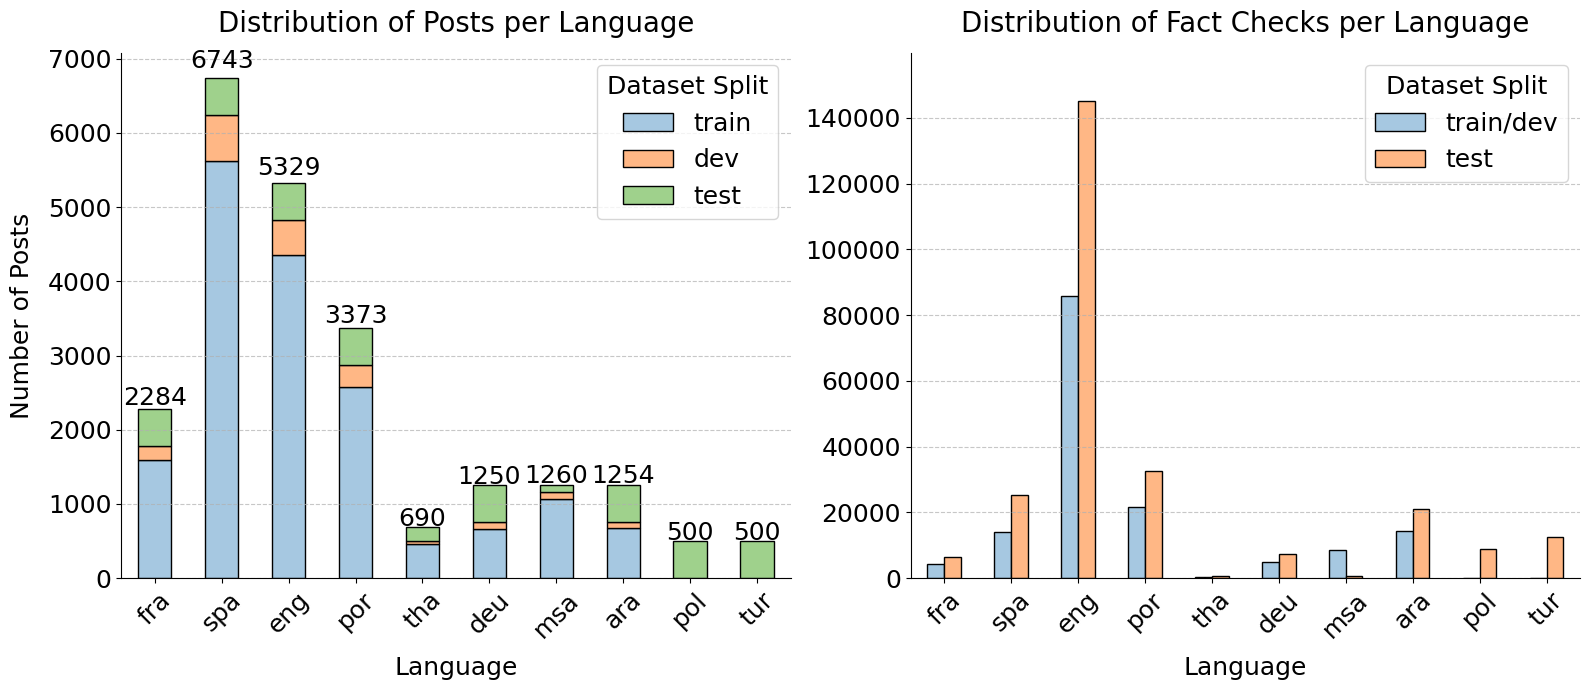

In [37]:
import os
import matplotlib.pyplot as plt
import pandas as pd

font_size = 18

df_fcs = df_fcs_final
# Drop total row and column
df_plot_fcs = df_fcs.iloc[:-1, :-1].T.rename(columns={"fact_checks": "train/dev", "fact_checks_test": "test"})
df_plot_posts = df_out_final.iloc[:-1, :-1].T

# Define colors for both plots
colors_posts = ["#A6C8E1", "#FFB785", "#9FD18C", "#E79C9C", "#C2A5D5", "#C8B8A2"]
colors_fcs = ["#A6C8E1", "#FFB785"]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

# First subplot: Distribution of Posts per Language
df_plot_posts.plot(kind="bar", stacked=True, color=colors_posts, edgecolor="black", ax=axes[0])
axes[0].set_title("Distribution of Posts per Language", fontsize=font_size * 1.1, pad=15)
axes[0].set_xlabel("Language", fontsize=font_size, labelpad=10)
axes[0].set_ylabel("Number of Posts", fontsize=font_size, labelpad=10)
axes[0].legend(title="Dataset Split", title_fontsize=font_size, fontsize=font_size, loc="upper right", frameon=True)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].tick_params(axis="x", rotation=45, labelsize=font_size)
axes[0].tick_params(axis="y", labelsize=font_size)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# Annotate total amount on top of each bar
totals_posts = df_plot_posts.sum(axis=1)
for i, total in enumerate(totals_posts):
    axes[0].text(i, total + total * 0.02, f"{int(total)}", ha='center', fontsize=font_size)

# Second subplot: Distribution of Fact Checks per Language
df_plot_fcs.plot(kind="bar", stacked=False, color=colors_fcs, edgecolor="black", ax=axes[1])
axes[1].set_title("Distribution of Fact Checks per Language", fontsize=font_size * 1.1, pad=15)
axes[1].set_xlabel("Language", fontsize=font_size, labelpad=10)
axes[1].legend(title="Dataset Split", title_fontsize=font_size, fontsize=font_size, loc="upper right", frameon=True)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].tick_params(axis="x", rotation=45, labelsize=font_size)
axes[1].tick_params(axis="y", labelsize=font_size)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

# # Annotate each value on top of each bar
# for i in range(df_fcs_final.shape[0] - 1):
#     for j in range(df_fcs_final.shape[1] - 1):
#         # if df_fcs_final.iloc[i, j] > 0:
#         axes[1].text(j + i * 0.5, df_fcs_final.iloc[i, j] * 1.03, f"{int(df_fcs_final.iloc[i, j])}", ha='right', fontsize=10)

axes[1].set_ylim(0, df_fcs_final.iloc[:-1, :-1].max().max() * 1.1)

# Adjust layout and save the figure
plt.tight_layout()
save_path = "nbs/data_exploration/plots/combined_fact_check_distribution.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, )
plt.show()


Text(0.5, 1.0, 'Number of fact check instances per language')

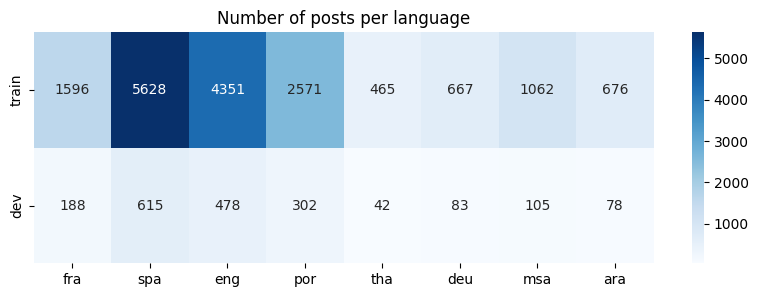

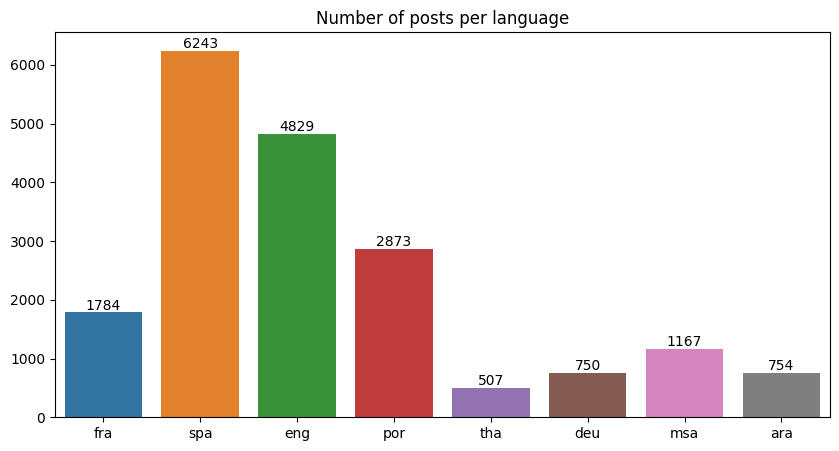

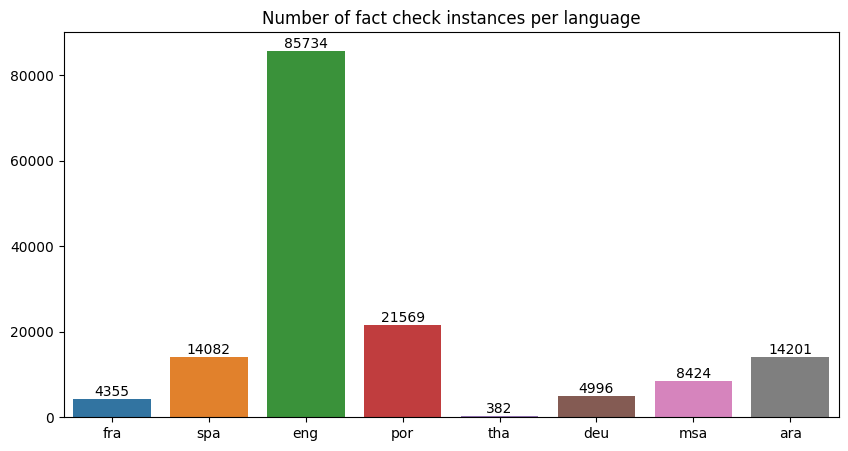

In [7]:
import collections

d_mono = posts.tasks["monolingual"]

d_posts = {}
d_fcs = {}
for lan in posts.langs:
    d_posts[lan] = {"train": [], "dev": [], "total": []}
    d_posts[lan]["train"].extend(d_mono[lan]["posts_train"])
    d_posts[lan]["dev"].extend(d_mono[lan]["posts_dev"])
    d_posts[lan]["total"] = d_posts[lan]["train"] + d_posts[lan]["dev"]
    
    d_fcs[lan] = {"fact_checks": []}
    d_fcs[lan]["fact_checks"].extend(d_mono[lan]["fact_checks"])
    
# Check if there are duplicates
for lan in d_posts:
    # print(f"Not overlapping posts for {lan}")
    assert len(d_posts[lan]["total"]) == len(set(d_posts[lan]["total"])), f"Duplicate posts found for {lan}"
    
    repeated = [item for item, count in collections.Counter(d_fcs[lan]["fact_checks"]).items() if count > 1]
    assert len(repeated) == 0, f"Duplicate fact checks found for {lan}"

df_posts_an = pd.DataFrame(d_posts)
df_out = df_posts_an.map(len)

df_fcs_an_0 = pd.DataFrame(d_fcs)
df_fcs_an = df_fcs_an_0.map(len)

# df_out = pd.concat([df_out, df_fcs_an], axis=0)

df_out["total"] = df_out.sum(axis=1)

plt.figure(figsize=(10, 3))
sns.heatmap(df_out.iloc[:-1, :-1], annot=True, fmt="d", cmap="Blues")
plt.title("Number of posts per language");

plt.figure(figsize=(10, 5))
sns.barplot(df_out.iloc[-1:, :-1])
plt.title("Number of posts per language");
for i in range(len(df_out.columns) -1):
    plt.text(i, df_out.iloc[-1, i], df_out.iloc[-1, i], ha='center', va='bottom')
    
plt.figure(figsize=(10, 5))
sns.barplot(df_fcs_an)
for i in range(len(df_fcs_an.columns)):
    plt.text(i, df_fcs_an.iloc[0, i], df_fcs_an.iloc[0, i], ha='center', va='bottom')
    
plt.title("Number of fact check instances per language")


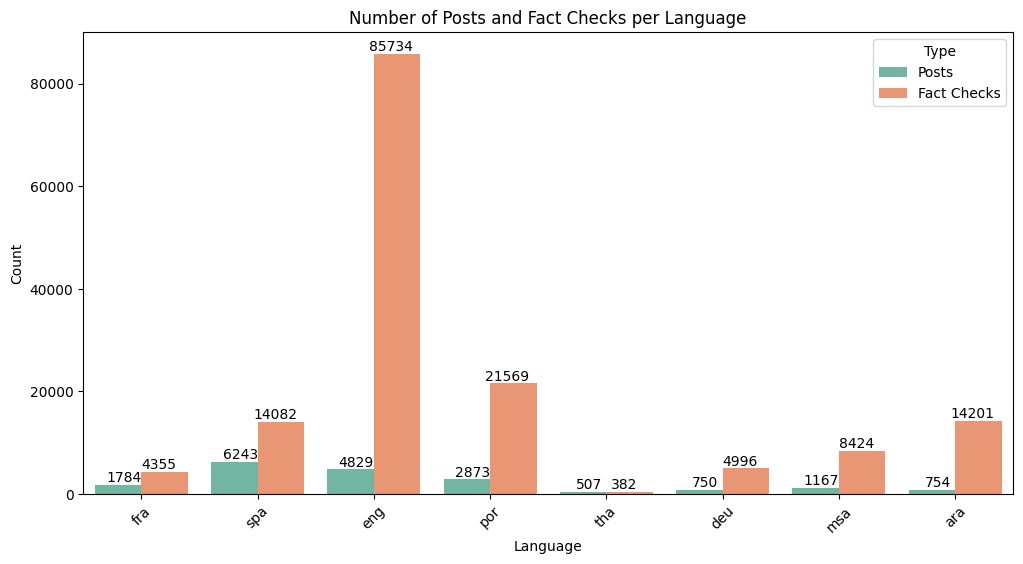

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare a combined DataFrame
df_combined = pd.DataFrame({
    "Language": df_out.columns[:-1],  # Exclude 'total' column
    "Posts": df_out.iloc[-1, :-1].values,  # Last row of df_out excluding 'total'
    "Fact Checks": df_fcs_an.iloc[0, :].values  # First row of df_fcs_an
})

# Convert to long format for seaborn
df_melted = df_combined.melt(id_vars="Language", var_name="Type", value_name="Count")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Language", y="Count", hue="Type", data=df_melted, palette="Set2")

# Add labels
for i in range(len(df_combined)):
    plt.text(i - 0.15, df_combined["Posts"][i], df_combined["Posts"][i], ha='center', va='bottom')
    plt.text(i + 0.15, df_combined["Fact Checks"][i], df_combined["Fact Checks"][i], ha='center', va='bottom')

plt.title("Number of Posts and Fact Checks per Language")
plt.xlabel("Language")
plt.ylabel("Count")
plt.legend(title="Type")
plt.xticks(rotation=45)
plt.show();


/tmp/ipykernel_18375/1391291001.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18)
/tmp/ipykernel_18375/1391291001.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticks(), fontsize=10)


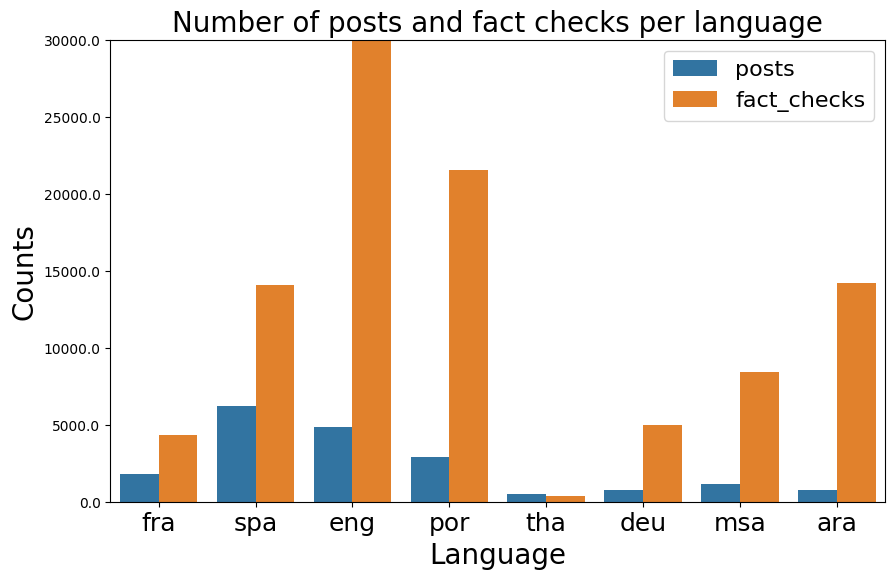

In [174]:
from tkinter import font


combined = pd.concat([df_out.iloc[-1:,:-1], df_fcs_an], axis=0).T
combined["lang"] = combined.index
combined.reset_index(drop=True, inplace=True)
combined.rename(columns={"total": "posts"}, inplace=True)
melted = pd.melt(combined, id_vars=["lang"], value_vars=["posts", "fact_checks"], var_name="type", value_name="counts")

fig, ax1 = plt.subplots(figsize=(10, 6))
g = sns.barplot(x="lang", y="counts", hue="type", data=melted, ax=ax1)
ax1.set_title("Number of posts and fact checks per language", fontsize=20)
ax1.set_ylabel("Counts", fontsize=20)
ax1.set_xlabel("Language", fontsize=20)
ax1.set_ylim(0, 30000)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=10)
plt.legend(fontsize=16)

plt.savefig("monolingual_stats.png")

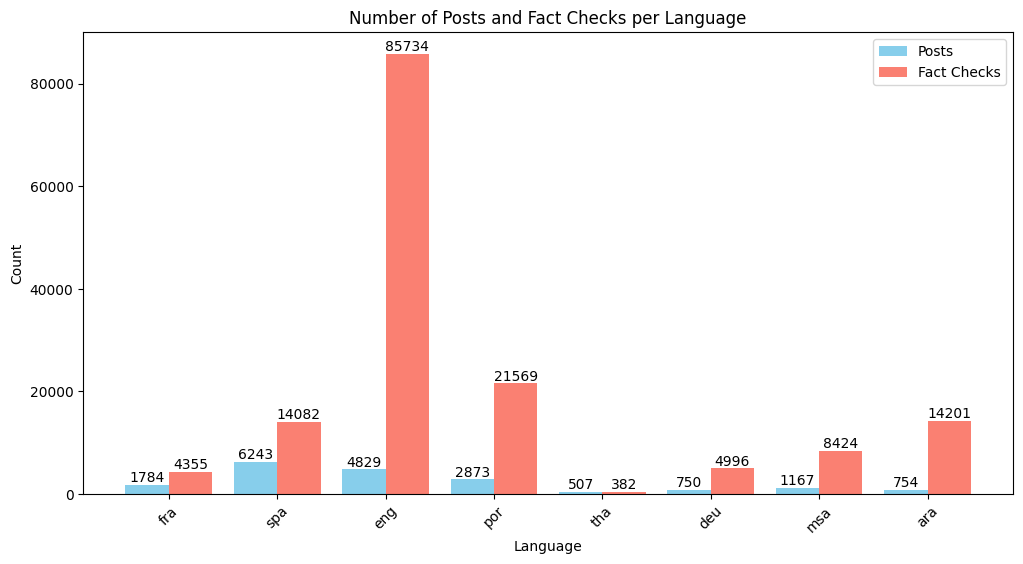

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare a combined DataFrame
df_combined = pd.DataFrame({
    "Language": df_out.columns[:-1],  # Exclude 'total' column
    "Posts": df_out.iloc[-1, :-1].values,  # Last row of df_out excluding 'total'
    "Fact Checks": df_fcs_an.iloc[0, :].values  # First row of df_fcs_an
})

# Create positions for bars
x = np.arange(len(df_combined))  # the label locations
width = 0.4  # width of the bars

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for posts
rects1 = ax.bar(x - width/2, df_combined["Posts"], width, label="Posts", color="skyblue")

# Create bars for fact checks
rects2 = ax.bar(x + width/2, df_combined["Fact Checks"], width, label="Fact Checks", color="salmon")

# Add labels
ax.set_xlabel("Language")
ax.set_ylabel("Count")
ax.set_title("Number of Posts and Fact Checks per Language")
ax.set_xticks(x)
ax.set_xticklabels(df_combined["Language"], rotation=45)
ax.legend()

# Annotate values on bars
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f"{int(height)}", ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f"{int(height)}", ha='center', va='bottom')

plt.show()


In [12]:
df_out

,fra,spa,eng,por,tha,deu,msa,ara,total
train,1596,5628,4351,2571,465,667,1062,676,17016
dev,188,615,478,302,42,83,105,78,1891
total,1784,6243,4829,2873,507,750,1167,754,18907


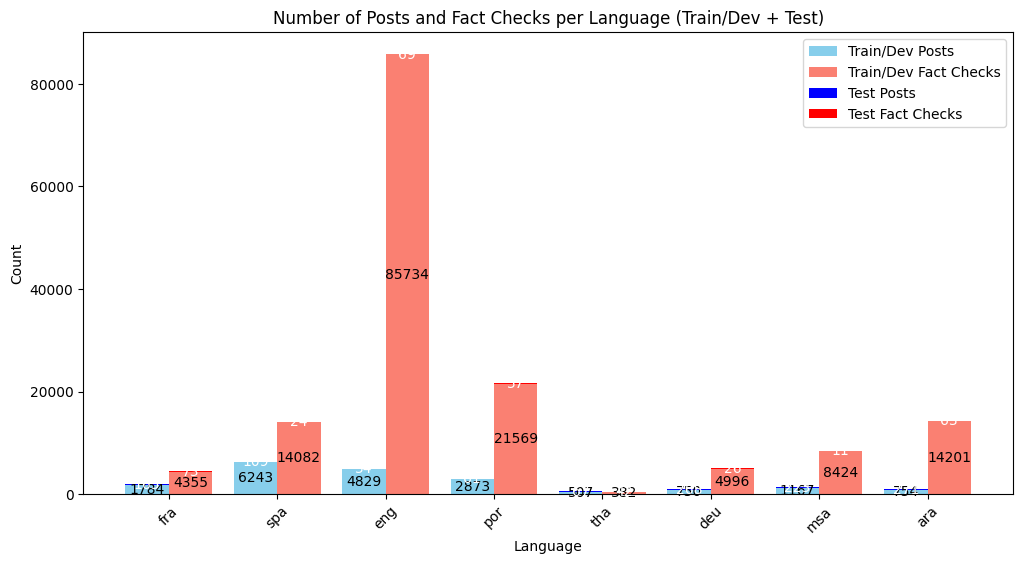

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Simulated test data (assuming same structure as df_out)
df_test = pd.DataFrame({
    "Language": df_out.columns[:-1],  # Exclude 'total' column
    "Test Posts": np.random.randint(50, 300, len(df_out.columns[:-1])),  # Replace with actual test data
    "Test Fact Checks": np.random.randint(10, 100, len(df_out.columns[:-1]))  # Replace with actual test data
})

# Merge test data with the original counts
df_combined = pd.DataFrame({
    "Language": df_out.columns[:-1],
    "Train/Dev Posts": df_out.iloc[-1, :-1].values,
    "Test Posts": df_test["Test Posts"].values,
    "Train/Dev Fact Checks": df_fcs_an.iloc[0, :].values,
    "Test Fact Checks": df_test["Test Fact Checks"].values
})

# Define bar positions
x = np.arange(len(df_combined))  # The label locations
width = 0.4  # Width of the bars

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Train/Dev bars
rects1 = ax.bar(x - width/2, df_combined["Train/Dev Posts"], width, label="Train/Dev Posts", color="skyblue")
rects2 = ax.bar(x + width/2, df_combined["Train/Dev Fact Checks"], width, label="Train/Dev Fact Checks", color="salmon")

# Test bars stacked on top
rects3 = ax.bar(x - width/2, df_combined["Test Posts"], width, bottom=df_combined["Train/Dev Posts"], label="Test Posts", color="blue")
rects4 = ax.bar(x + width/2, df_combined["Test Fact Checks"], width, bottom=df_combined["Train/Dev Fact Checks"], label="Test Fact Checks", color="red")

# Labels and formatting
ax.set_xlabel("Language")
ax.set_ylabel("Count")
ax.set_title("Number of Posts and Fact Checks per Language (Train/Dev + Test)")
ax.set_xticks(x)
ax.set_xticklabels(df_combined["Language"], rotation=45)
ax.legend()

# Annotate values on bars
for rect1, rect3 in zip(rects1, rects3):
    h1 = rect1.get_height()
    h3 = rect3.get_height()
    ax.text(rect1.get_x() + rect1.get_width()/2, h1/2, f"{int(h1)}", ha='center', va='center', color="black")
    ax.text(rect3.get_x() + rect3.get_width()/2, h1 + h3/2, f"{int(h3)}", ha='center', va='center', color="white")

for rect2, rect4 in zip(rects2, rects4):
    h2 = rect2.get_height()
    h4 = rect4.get_height()
    ax.text(rect2.get_x() + rect2.get_width()/2, h2/2, f"{int(h2)}", ha='center', va='center', color="black")
    ax.text(rect4.get_x() + rect4.get_width()/2, h2 + h4/2, f"{int(h4)}", ha='center', va='center', color="white")

plt.show()


In [ ]:
df_out

,fra,spa,eng,por,tha,deu,msa,ara,total
train,1596,5628,4351,2571,465,667,1062,676,17016
dev,188,615,478,302,42,83,105,78,1891
total,1784,6243,4829,2873,507,750,1167,754,18907


In [142]:
df_fcs_an.sum(axis=1)

fact_checks    153743
dtype: int64

In [147]:
ls_fcs = df_fcs_an_0.sum(axis=1).iloc[0]
print("All of them different?", len(list(set(ls_fcs))) == len(ls_fcs))

All of them different? True


## Cross-lingual

In [141]:
d_cross = posts.tasks["crosslingual"]
print("Total:", len(d_cross["posts_train"] + d_cross["posts_dev"]))
print("Train:", len(d_cross["posts_train"]))
print("Dev:", len(d_cross["posts_dev"]))

print("Total fact checks:", len(d_cross["fact_checks"]))

Total: 5524
Train: 4972
Dev: 552
Total fact checks: 153743


# Example

In [32]:
sample_1 = df_train_en[(df_train_en["text"].str.split(" ").apply(len).between(3, 15))&(df_train_en["ocr"].str.split(" ").apply(len).between(3, 15))&(df_train_en["verdicts"] != "")].sample(1, random_state=100).iloc[:1, :]

print(sample_1.iloc[0].to_markdown())
print("\n")
print(df_fc.loc[sample_1["gs"].values[0]].iloc[0].to_markdown())


|           | 8626                                                                                              |
|:----------|:--------------------------------------------------------------------------------------------------|
| ocr       | odas Don't talk on the phone while on charge SUL                                                  |
| verdicts  | Missing context                                                                                   |
| text      | Do not talk on the phone, while it is charging!!                                                  |
| lan       | eng                                                                                               |
| fb        | 1                                                                                                 |
| tw        | 0                                                                                                 |
| ig        | 0                                                                         

In [ ]:
print(f"There are {len(posts)} posts")

There are 24431 posts


In [182]:
posts.df_train

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
2,"""Actually, he's a damn sight better than any o...",Missing context,,eng,2,0,0,"""Actually, he's a damn sight better than any o...",[93524]
5,"""Cigarette smoking does not cause cancer."" -Ce...",False information,,eng,1,0,0,"""Cigarette smoking does not cause cancer."" -Ce...",[33862]
13,"""Environmentalists"" Say Fracking is Evil 53-58...",Partly false information,,eng,1,0,0,"""Environmentalists"" Say Fracking is Evil 53-58...",[153628]
14,"""Environmentalists"" Say Fracking is Evil SAPER...",Partly false information,,eng,1,0,0,"""Environmentalists"" Say Fracking is Evil SAPER...",[153628]
15,"""Environmentalists"" Say Fracking is Evil This ...",Partly false information,,eng,2,0,0,"""Environmentalists"" Say Fracking is Evil This ...",[153628]
...,...,...,...,...,...,...,...,...,...
28044,COVID has killed 1.6M people in the world and ...,False information,🤦🏾 ♂️🙏🏾🙏🏾,eng,1,0,0,COVID has killed 1.6M people in the world and ...,[63100]
28048,,False information,🤩Why Every Judge On Shark Tank Backed This Pro...,eng,1,0,0,🤩Why Every Judge On Shark Tank Backed This Pr...,[119661]
28061,"Boris Johnson's dad, Stanley, wrote a novel in...",,🤷,eng,1,0,0,"Boris Johnson's dad, Stanley, wrote a novel in...",[32679]


In [37]:
sample_eng = posts.df_train
print(sample_eng[(sample_eng["ocr"] != "")&(sample_eng["text"].str.contains("Trump"))&(sample_eng["verdicts"] != "")&(sample_eng["gs"].apply(len) > 1)].sample(1, random_state=42).to_markdown())

|   post_id | ocr                                                                                                                                                                                                      | verdicts          | text                                                                                                       | lan   |   fb |   tw |   ig | full_text                                                                                                                                                                                                                                                                                                           | gs                      |
|----------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------|:----------------------------------------------------

In [40]:
len(posts.idx_train)

4351

In [48]:
20309 in posts.tasks["monolingual"]["eng"]["posts_train"]

True

In [49]:
sample_eng[sample_eng["lan"] == "other"]

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs
post_id,,,,,,,,,
213,1986-1992 910Mannu7 2009-2016 Ang madilim na k...,Partly false information,,other,1,0,0,1986-1992 910Mannu7 2009-2016 Ang madilim na k...,[102741]
3458,COVID-19 SYMPTOMS DAY 4 sore throat- hoarse-vo...,Partly false information,#MasMasayaSaBongabong #MalaluanCandelarioAdmin...,other,1,0,0,COVID-19 SYMPTOMS DAY 4 sore throat- hoarse-vo...,[72512]
3466,Maria Wirth [USER] - 18h Just wondering... Is ...,False information,#ModiHaiToMumkinHai #ModiHainTohMumkinHain,other,1,0,0,Maria Wirth [USER] - 18h Just wondering... Is ...,[104269]
3511,news24 Breaking News. First BREAKING: Vladamir...,False information,#NouMaakPuttinVirMalemaBaieKwaad!!! 😂😂😂,other,1,0,0,news24 Breaking News. First BREAKING: Vladamir...,[93679]
4007,Mount Lavinia Railway Station COLOMBO FORT RAI...,Partly false information,#චයිනීස්_ෆස්ට්😥😥😥,other,1,0,0,Mount Lavinia Railway Station COLOMBO FORT RAI...,[69213]
...,...,...,...,...,...,...,...,...,...
26576,DANGEROUS DI PALEVSKY HOW VAX REPRODUCTIVE SYS...,Partly false information,독신 쇼🧬 합법적 살인💰,other,1,0,0,DANGEROUS DI PALEVSKY HOW VAX REPRODUCTIVE SYS...,[95258]
26684,Reuters ✔ REUTERS [USER] South Korea's Moon se...,Partly false information,이 판국에도 북한에 백신지원 요청하는 바보가 한국 대통령 [URL],other,1,0,0,Reuters ✔ REUTERS [USER] South Korea's Moon se...,[121310]
26714,HEEL WEREY PRLSBAD www. DHAK 限定,,좆선아,other,1,0,0,HEEL WEREY PRLSBAD www. DHAK 限定 좆선아,[131858]


In [9]:
fact_checks_fra = TextConcatFactCheck(FACT_CHECKS_PATH, TASKS_PATH, task_name=TASK_NAME, lang="fra")
print(f"Loaded {len(fact_checks)}")

Loaded 4355


In [10]:
fact_checks.df

,claim,instances,title,full_text
fact_check_id,,,,
15,""" Il y a une vidéo qui sera lancée demain à Wh...",[https://www.20minutes.fr/high-tech/3216775-20...,WhatsApp : Une vidéo « Martinelli » qui va con...,WhatsApp : Une vidéo « Martinelli » qui va con...
136,"""1960 on n’était que 3% des femmes alphabétisé...",[http://africacheck.org/fr/fact-checks/article...,Fatou Sarr Sow se trompe sur le taux d’alphabé...,Fatou Sarr Sow se trompe sur le taux d’alphabé...
155,"""25% des effets secondaires liés aux vaccins s...",[https://www.liberation.fr/checknews/est-il-vr...,Est-il vrai que 25% des effets secondaires des...,Est-il vrai que 25% des effets secondaires des...
156,"""26 groupes armés"" ont rendu les armes dans la...",[https://factuel.afp.com/non-les-autorites-con...,"Non, les autorités congolaises n’ont pas enreg...","Non, les autorités congolaises n’ont pas enreg..."
187,"""5 % des élèves consomment de la drogue"".",[http://africacheck.org/fr/fact-checks/article...,Sénégal : 5 % des élèves consomment-ils de la ...,Sénégal : 5 % des élèves consomment-ils de la ...
...,...,...,...,...
156402,«Vous avez licencié 15 000 soignants [...] par...,[https://www.dna.fr/societe/2022/04/22/15-000-...,Désinfox 15 000 SOIGNANTS ONT-ILS ÉTÉ LICENCIÉ...,Désinfox 15 000 SOIGNANTS ONT-ILS ÉTÉ LICENCIÉ...
156686,À 74 ans elle donne naissance à un nouveau née,[https://factuel.afp.com/faux-ces-deux-images-...,"Faux, ces deux images n'ont aucun lien et ne m...","Faux, ces deux images n'ont aucun lien et ne m..."
156687,"À Hong Kong, des gens détruisent des tours de ...",[https://dpa-factchecking.com/belgium/220512-9...,Un lampadaire « intelligent » détruit par des ...,Un lampadaire « intelligent » détruit par des ...
